# Photometry

This is the sixth in a series of notebooks related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the previous lesson we downloaded photometry data from Pan-STARRS, which is available from the same server we've been using to get Gaia data. 

The next step in the analysis is to select candidate stars based on the photometry data.  
The following figure from the paper is a color-magnitude diagram showing the stars we previously selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a theoretical isochrone, showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from mostly younger background stars.

## Outline

Here are the steps in this notebook:

1. We'll reload the data from the previous notebook and make a color-magnitude diagram.

2. We'll use an isochrone computed by MIST to specify a polygonal region in the color-magnitude diagram and select the stars inside it.

3. Then we'll merge the photometry data with the list of candidate stars, storing the result in a Pandas `DataFrame`.

After completing this lesson, you should be able to

* Use Matplotlib to specify a `Polygon` and determine which points fall inside it.

* Use Pandas to merge data from multiple `DataFrames`, much like a database `JOIN` operation.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala wget

## Reload the data

The following cell downloads the photometry data we created in the previous notebook.

In [2]:
import os
from wget import download

filename = 'gd1_photo.fits'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read the data back into an Astropy `Table`.

In [3]:
from astropy.table import Table

photo_table = Table.read(filename)

## Plotting photometry data

Now that we have photometry data from Pan-STARRS, we can replicate the [color-magnitude diagram](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram) from the original paper:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The y-axis shows the apparent magnitude of each source with the [g filter](https://en.wikipedia.org/wiki/Photometric_system).

The x-axis shows the difference in apparent magnitude between the g and i filters, which indicates color.

Stars with lower values of (g-i) are brighter in g-band than in i-band, compared to other stars, which means they are bluer.

Stars in the lower-left quadrant of this diagram are less bright and less metallic than the others, which means they are [likely to be older](http://spiff.rit.edu/classes/ladder/lectures/ordinary_stars/ordinary.html).

Since we expect the stars in GD-1 to be older than the background stars, the stars in the lower-left are more likely to be in GD-1.

The following function takes a table containing photometry data and draws a color-magnitude diagram.
The input can be an Astropy `Table` or Pandas `DataFrame`, as long as it has columns named `g_mean_psf_mag` and `i_mean_psf_mag`.



In [4]:
import matplotlib.pyplot as plt

def plot_cmd(table):
    """Plot a color magnitude diagram.
    
    table: Table or DataFrame with photometry data
    """
    y = table['g_mean_psf_mag']
    x = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlim([0, 1.5])
    plt.ylim([14, 22])
    plt.gca().invert_yaxis()

    plt.ylabel('$g_0$')
    plt.xlabel('$(g-i)_0$')

`plot_cmd` uses a new function, `invert_yaxis`, to invert the `y` axis, which is conventional when plotting magnitudes, since lower magnitude indicates higher brightness.

`invert_yaxis` is a little different from the other functions we've used.  You can't call it like this:

```
plt.invert_yaxis()          # doesn't work
```

You have to call it like this:

```
plt.gca().invert_yaxis()          # works
```

`gca` stands for "get current axis".  It returns an object that represents the axes of the current figure, and that object provides `invert_yaxis`.

**In case anyone asks:** The most likely reason for this inconsistency in the interface is that `invert_yaxis` is a lesser-used function, so it's not made available at the top level of the interface.

Here's what the results look like.

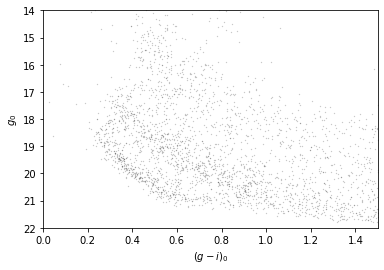

In [5]:
plot_cmd(photo_table)

Our figure does not look exactly like the one in the paper because we are working with a smaller region of the sky, so we don't have as many stars.  But we can see an overdense region in the lower left that contains stars with the photometry we expect for GD-1.

In the next section we'll use an isochrone to specify a polygon that contains this overdense regioin.

## Isochrone

Based on our best estimates for the ages of the stars in GD-1 and their metallicity, we can compute a [stellar isochrone](https://en.wikipedia.org/wiki/Stellar_isochrone) that predicts the relationship between their magnitude and color.

In fact, we can use [MESA Isochrones & Stellar Tracks](http://waps.cfa.harvard.edu/MIST/) (MIST) to compute it for us.

Using the [MIST Version 1.2 web interface](http://waps.cfa.harvard.edu/MIST/interp_isos.html), we computed an isochrone with the following parameters:
    
* Rotation initial v/v_crit = 0.4

* Single age, linear scale = 12e9

* Composition [Fe/H] = -1.35

* Synthetic Photometry, PanStarrs

* Extinction av = 0

The following cell downloads the results:

In [6]:
import os
from wget import download

filename = 'MIST_iso_5fd2532653c27.iso.cmd'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

To read this file we'll download a Python module [from this repository](https://github.com/jieunchoi/MIST_codes).

In [7]:
import os
from wget import download

filename = 'read_mist_models.py'
filepath = 'https://github.com/jieunchoi/MIST_codes/raw/master/scripts/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read the file:

In [8]:
import read_mist_models

filename = 'MIST_iso_5fd2532653c27.iso.cmd'
iso = read_mist_models.ISOCMD(filename)

Reading in: MIST_iso_5fd2532653c27.iso.cmd


The result is an `ISOCMD` object.

In [9]:
type(iso)

read_mist_models.ISOCMD

It contains a list of arrays, one for each isochrone.

In [10]:
type(iso.isocmds)

list

We only got one isochrone.

In [11]:
len(iso.isocmds)

1

So we can select it like this:

In [12]:
iso_array = iso.isocmds[0]

It's a NumPy array:

In [13]:
type(iso_array)

numpy.ndarray

But it's an unusual NumPy array, because it contains names for the columns.

In [14]:
iso_array.dtype

dtype([('EEP', '<i4'), ('isochrone_age_yr', '<f8'), ('initial_mass', '<f8'), ('star_mass', '<f8'), ('log_Teff', '<f8'), ('log_g', '<f8'), ('log_L', '<f8'), ('[Fe/H]_init', '<f8'), ('[Fe/H]', '<f8'), ('PS_g', '<f8'), ('PS_r', '<f8'), ('PS_i', '<f8'), ('PS_z', '<f8'), ('PS_y', '<f8'), ('PS_w', '<f8'), ('PS_open', '<f8'), ('phase', '<f8')])

Which means we can select columns using the bracket operator:

In [15]:
iso_array['phase']

array([0., 0., 0., ..., 6., 6., 6.])

We can use `phase` to select the part of the isochrone for stars in the main sequence and red giant phases.

In [16]:
phase_mask = (iso_array['phase'] >= 0) & (iso_array['phase'] < 3)
phase_mask.sum()

354

In [17]:
main_sequence = iso_array[phase_mask]
len(main_sequence)

354

The other two columns we'll use are `PS_g` and `PS_i`, which contain simulated photometry data for stars with the given age and metallicity, based on a model of the Pan-STARRS sensors.

We'll use these columns to superimpose the isochrone on the color-magnitude diagram, but first we have to use a [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) to scale the isochrone based on the estimated distance of GD-1.

We can use the `Distance` object from Astropy to compute the distance modulus.

In [18]:
import astropy.coordinates as coord
import astropy.units as u

distance = 7.8 * u.kpc
distmod = coord.Distance(distance).distmod.value
distmod

14.4604730134524

Now we can compute the scaled magnitude and color of the isochrone.

In [19]:
g = main_sequence['PS_g'] + distmod
gi = main_sequence['PS_g'] - main_sequence['PS_i']

To make this data easier to work with, we'll put it in a Pandas `Series` with that contains `gi` as the index and `g` as the values.

In [20]:
import pandas as pd

iso_series = pd.Series(g, index=gi)
iso_series.head()

2.195021    28.294743
2.166076    28.189718
2.129312    28.051761
2.093721    27.916194
2.058585    27.780024
dtype: float64

Now we can plot it on the color-magnitude diagram like this.

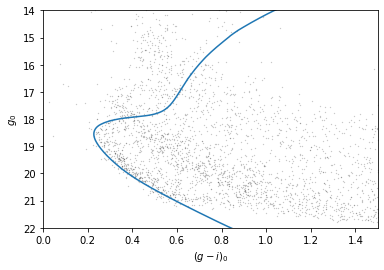

In [21]:
plot_cmd(photo_table)
iso_series.plot();

The theoretical isochrone passes through the overdense region where we expect to find stars in GD-1.

Let's save this result so we can reload it later without repeating the steps in this section.

In [22]:
filename = 'gd1_isochrone.hdf5'

iso_series.to_hdf(filename, 'iso_series')

## Making a polygon

The following cell downloads the isochrone series we made in the previous section, if necessary.

In [23]:
import os
from wget import download

filename = 'gd1_isochrone.hdf5'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

Now we can read the isochrone back in.

In [24]:
iso_series = pd.read_hdf(filename, 'iso_series')
iso_series.head()

2.195021    28.294743
2.166076    28.189718
2.129312    28.051761
2.093721    27.916194
2.058585    27.780024
dtype: float64

To select the stars in the overdense region of the color-magnitude diagram, we want to stretch the isochrone into a polygon.

We'll use the following formulas to compute the left and right sides of the polygons.

In [25]:
g = iso_series.to_numpy()
gi = iso_series.index

In [26]:
left_gi = gi - 0.4 * (g/28)**5
right_gi = gi + 0.7 * (g/28)**5

To explain the terms:

* We divide magnitudes by 28 to normalize them onto the range from 0 to 1.

* Raising the normalized magnitudes to the 5th power [DOES WHAT?]

* Then we add and subtract the result from `gi` to shift the isochrone left and right.  The factors 0.4 and 0.7 were chosen by eye to enclose the overdense region.

To make the shifted isochrones easier to work with, we'll put them in a Pandas `Series` with that contains both `g` and the scaled values of `gi`.

In [27]:
import pandas as pd

left_series = pd.Series(g, index=left_gi)
left_series.head()

1.773520    28.294743
1.752340    28.189718
1.725601    28.051761
1.699671    27.916194
1.674053    27.780024
dtype: float64

In [28]:
right_series = pd.Series(g, index=right_gi)
right_series.head()

2.932648    28.294743
2.890114    28.189718
2.835806    28.051761
2.783308    27.916194
2.731517    27.780024
dtype: float64

Now we can plot them on the color-magnitude diagram like this.

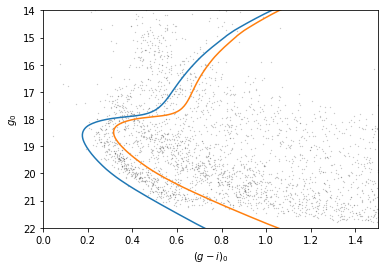

In [29]:
plot_cmd(photo_table)
left_series.plot()
right_series.plot();

It looks like the scaled isochrones bound the overdense area well, but they also include stars with magnitudes higher than we expect for stars in GD-1, so we'll use another mask to limit the range of `g`.

In [30]:
g_mask = (g > 18.0) & (g < 21.5)
g_mask.sum()

117

In [31]:
left = left_series[g_mask]
right = right_series[g_mask]

len(left), len(right)

(117, 117)

Here's what they look like:

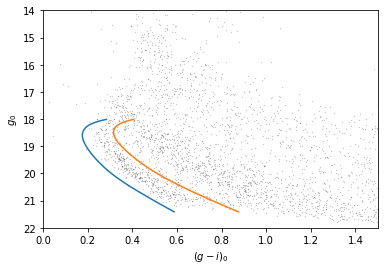

In [32]:
plot_cmd(photo_table)
left.plot()
right.plot();

Now we want to assemble the two halves into a polygon.  We can use `append` to make a new `Series` that contains both halves.

And we'll use the slice `[::-1]` to reverse the elements of `right` so the result forms a loop.  [See here for an explanation of this idiom](https://stackoverflow.com/questions/5876998/reversing-a-list-using-slice-notation).

In [33]:
loop = left.append(right[::-1])
loop.head()

0.587571    21.411746
0.567801    21.322466
0.548134    21.233380
0.528693    21.144427
0.509300    21.054549
dtype: float64

The following lines add metadata by assigning names to the values and the index in `loop`.

In [34]:
loop.name = 'g'
loop.index.name = 'gi'
loop.head()

gi
0.587571    21.411746
0.567801    21.322466
0.548134    21.233380
0.528693    21.144427
0.509300    21.054549
Name: g, dtype: float64

And here's what it looks like

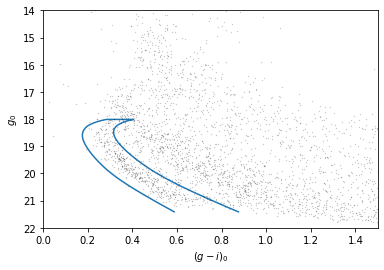

In [35]:
loop.plot()
plot_cmd(photo_table)

Next we'll use this polygon to identify stars in the overdense region.

## Which points are in the polygon?

Matplotlib provides a `Path` object that we can use to check which points fall in the polygon we just constructed.

To make a `Path`, we need a list of coordinates in the form of an array with two columns.

Currently `loop` is a `Series` with the values of `gi` in the index:

In [36]:
loop.head()

gi
0.587571    21.411746
0.567801    21.322466
0.548134    21.233380
0.528693    21.144427
0.509300    21.054549
Name: g, dtype: float64

We can move them out of the index into a column using `reset_index`:

In [37]:
loop_df = loop.reset_index()
loop_df.head()

,gi,g
0,0.587571,21.411746
1,0.567801,21.322466
2,0.548134,21.233380
3,0.528693,21.144427
4,0.509300,21.054549


The result is a `DataFrame` with one column for `gi` and one column for `g`, so we can pass it to `Path` like this:

In [38]:
from matplotlib.path import Path

path = Path(loop_df)
path

Path(array([[ 0.58757135, 21.41174601],
       [ 0.56780097, 21.32246601],
       [ 0.54813409, 21.23338001],
       [ 0.5286928 , 21.14442701],
       [ 0.50929987, 21.05454901],
       [ 0.48991266, 20.96383501],
       [ 0.47084777, 20.87386601],
       [ 0.45222635, 20.78511001],
       [ 0.43438902, 20.69865301],
       [ 0.42745198, 20.66469601],
       [ 0.42067029, 20.63135301],
       [ 0.41402867, 20.59850601],
       [ 0.40738016, 20.56529901],
       [ 0.40088387, 20.53264001],
       [ 0.39449608, 20.50023501],
       [ 0.38843797, 20.46871801],
       [ 0.38251577, 20.43765101],
       [ 0.3766547 , 20.40653701],
       [ 0.37088531, 20.37564701],
       [ 0.36522325, 20.34505401],
       [ 0.35962415, 20.31443001],
       [ 0.35413292, 20.28413501],
       [ 0.34871894, 20.25390101],
       [ 0.34339273, 20.22385701],
       [ 0.33815825, 20.19395801],
       [ 0.33305724, 20.16427301],
       [ 0.32820637, 20.13508501],
       [ 0.32348139, 20.10604901],
       [ 0.3188

The result is a `Path` object that represents the polygon.

`Path` provides `contains_points`, which figures out which points are inside the polygon.

To test it, we'll create a list with two points, one inside the polygon and one outside.

In [39]:
points = [(0.4, 20), 
          (0.4, 16)]

Now we can make sure `contains_points` does what we expect.

In [40]:
inside = path.contains_points(points)
inside

array([ True, False])

The result is an array of Boolean values.

We are almost ready to select stars whose photometry data falls in this polygon.  But first we need to do some data cleaning.

## Reloading the data

Now we need to combine the photometry data with the list of candidate stars we identified in a previous notebook.  The following cell downloads it:



In [41]:
import os
from wget import download

filename = 'gd1_candidates.hdf5'
filepath = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(filepath+filename))

In [42]:
import pandas as pd

candidate_df = pd.read_hdf(filename, 'candidate_df')

`candidate_df` is the Pandas DataFrame that contains the results from Lesson 4, which selects stars likely to be in GD-1 based on proper motion.  It also includes position and proper motion transformed to the ICRS frame.

## Merging photometry data

Before we select stars based on photometry data, we have to solve two problems:

1. We only have Pan-STARRS data for some stars in `candidate_df`.

2. Even for the stars where we have Pan-STARRS data in `photo_table`, some photometry data is missing.

We will solve these problems in two step:

1. We'll merge the data from `candidate_df` and `photo_table` into a single Pandas `DataFrame`.

2. We'll use Pandas functions to deal with missing data.

`candidate_df` is already a `DataFrame`, but `results` is an Astropy `Table`.  Let's convert it to Pandas:

In [43]:
photo_df = photo_table.to_pandas()

for colname in photo_df.columns:
    print(colname)

source_id
g_mean_psf_mag
i_mean_psf_mag


Now we want to combine `candidate_df` and `photo_df` into a single table, using `source_id` to match up the rows.

You might recognize this task; it's the same as the JOIN operation in ADQL/SQL.

Pandas provides a function called `merge` that does what we want.  Here's how we use it.

In [44]:
merged = pd.merge(candidate_df, 
                  photo_df, 
                  on='source_id', 
                  how='left')
merged.head()

,source_id,ra,dec,pmra,pmdec,parallax,radial_velocity,phi1,phi2,pm_phi1,pm_phi2,g_mean_psf_mag,i_mean_psf_mag
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,NaN,-59.630489,-1.216485,-7.361363,-0.592633,NaN,NaN
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,NaN,-59.247330,-2.016078,-7.527126,1.748779,17.8978,17.517401
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,NaN,-59.133391,-2.306901,-7.560608,-0.741800,19.2873,17.678101
3,635535454774983040,137.837752,18.864007,-4.335041,-14.492309,0.314514,NaN,-59.785300,-1.594569,-9.357536,-1.218492,16.9238,16.478100
4,635497276810313600,138.044516,19.009471,-7.172931,-12.291499,0.425404,NaN,-59.557744,-1.682147,-9.000831,2.334407,19.9242,18.334000


The first argument is the "left" table, the second argument is the "right" table, and the keyword argument `on='source_id'` specifies a column to use to match up the rows.

The argument `how='left'` means that the result should have all rows from the left table, even if some of them don't match up with a row in the right table.

If you are interested in the other options for `how`, you can [read the documentation of `merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html).

You can also do different types of join in ADQL/SQL; [you can read about that here](https://www.w3schools.com/sql/sql_join.asp).

The result is a `DataFrame` that contains the same number of rows as `candidate_df`. 

In [45]:
len(candidate_df), len(photo_df), len(merged)

(7346, 3724, 7346)

And all columns from both tables.

In [46]:
for colname in merged.columns:
    print(colname)

source_id
ra
dec
pmra
pmdec
parallax
radial_velocity
phi1
phi2
pm_phi1
pm_phi2
g_mean_psf_mag
i_mean_psf_mag


**Detail** You might notice that Pandas also provides a function called `join`; it does almost the same thing, but the interface is slightly different.  We think `merge` is a little easier to use, so that's what we chose.  It's also more consistent with JOIN in SQL, so if you learn how to use `pd.merge`, you are also learning how to use SQL JOIN.

Also, someone might ask why we have to use Pandas to do this join; why didn't we do it in ADQL.  The answer is that we could have done that, but since we already have the data we need, we should probably do the computation locally rather than make another round trip to the Gaia server.

## Missing data

Let's add columns to the merged table for magnitude and color.

In [47]:
merged['mag'] = merged['g_mean_psf_mag']
merged['color'] = merged['g_mean_psf_mag'] - merged['i_mean_psf_mag']

These columns contain the special value `NaN` where we are missing data.

We can use `notnull` to see which rows contain value data, that is, not null values.

In [48]:
merged['color'].notnull()

0       False
1        True
2        True
3        True
4        True
        ...  
7341     True
7342    False
7343    False
7344     True
7345    False
Name: color, Length: 7346, dtype: bool

And `sum` to count the number of valid values.

In [49]:
merged['color'].notnull().sum()

3724

For scientific purposes, it's not obvious what we should do with candidate stars if we don't have photometry data.  Should we give them the benefit of the doubt or leave them out?

In part the answer depends on the goal: are we trying to identify more stars that might be in GD-1, or a smaller set of stars that have higher probability?

In the next section, we'll leave them out, but you can experiment with the alternative.

## Selecting based on photometry

Now let's see how many of these points are inside the polygon we chose.

We can use a list of column names to select `color` and `mag`.

In [50]:
points = merged[['color', 'mag']]
points.head()

,color,mag
0,NaN,NaN
1,0.3804,17.8978
2,1.6092,19.2873
3,0.4457,16.9238
4,1.5902,19.9242


The result is a `DataFrame` that can be treated as a sequence of coordinates, so we can pass it to `contains_points`:

In [51]:
inside = path.contains_points(points)
inside

array([False, False, False, ..., False, False, False])

The result is a Boolean array.  We can use `sum` to see how many stars fall in the polygon.

In [52]:
inside.sum()

464

Now we can use `inside` as a mask to select stars that fall inside the polygon.

In [53]:
selected2 = merged[inside]

Let's make a color-magnitude plot one more time, highlighting the selected stars with green `x` marks.

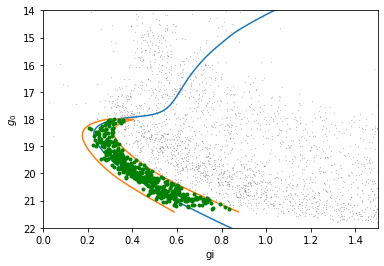

In [54]:
plot_cmd(photo_table)
plt.plot(gi, g)
loop.plot()

plt.plot(selected2['color'], selected2['mag'], 'g.');

It looks like the selected stars are, in fact, inside the polygon, which means they have photometry data consistent with GD-1.

Finally, we can plot the coordinates of the selected stars:

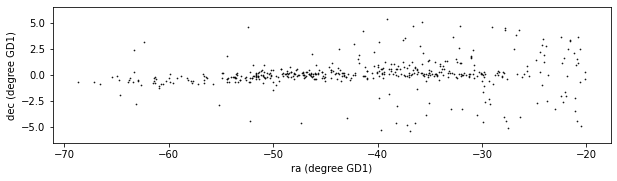

In [55]:
plt.figure(figsize=(10,2.5))

x = selected2['phi1']
y = selected2['phi2']

plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');

This example includes two new Matplotlib commands:

* `figure` creates the figure.  In previous examples, we didn't have to use this function; the figure was created automatically.  But when we call it explicitly, we can provide arguments like `figsize`, which sets the size of the figure.

* `axis` with the parameter `equal` sets up the axes so a unit is the same size along the `x` and `y` axes.

In an example like this, where `x` and `y` represent coordinates in space, equal axes ensures that the distance between points is represented accurately.   

## Write the data

Let's write the merged DataFrame to a file.

In [56]:
filename = 'gd1_merged.hdf5'

merged.to_hdf(filename, 'merged')
selected2.to_hdf(filename, 'selected2')

In [57]:
!ls -lh gd1_merged.hdf5

-rw-rw-r-- 1 downey downey 1.1M Dec 14 14:24 gd1_merged.hdf5


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_merged.hdf5
```

## Save the polygon

[Reproducibile research](https://en.wikipedia.org/wiki/Reproducibility#Reproducible_research) is "the idea that ... the full computational environment used to produce the results in the paper such as the code, data, etc. can be used to reproduce the results and create new work based on the research."

This Jupyter notebook is an example of reproducible research because it contains all of the code needed to reproduce the results, including the database queries that download the data and and analysis.

In this lesson we used an isochrone to derive a polygon, which we used to select stars based on photometry. 
So it is important to record the polygon as part of the data analysis pipeline.

Here's how we can save it in an HDF file.

In [58]:
filename = 'gd1_polygon.hdf5'
loop.to_hdf(filename, 'loop')

We can read it back like this.

In [59]:
loop2 = pd.read_hdf(filename, 'loop')

And verify that the data we read back is the same.

In [60]:
import numpy as np

np.all(loop == loop2)

True

## Summary

In this notebook, we worked with two datasets: the list of candidate stars from Gaia and the photometry data from Pan-STARRS.

We drew a color-magnitude diagram and used it to identify stars we think are likely to be in GD-1.

Then we used a Pandas `merge` operation to combine the data into a single `DataFrame`.

## Best practices

* If you want to perform something like a database `JOIN` operation with data that is in a Pandas `DataFrame`, you can use the `join` or `merge` function.  In many cases, `merge` is easier to use because the arguments are more like SQL.

* Use Matplotlib options to control the size and aspect ratio of figures to make them easier to interpret.  In this example, we scaled the axes so the size of a degree is equal along both axes.

* Matplotlib also provides operations for working with points, polygons, and other geometric entities, so it's not just for making figures.

* Be sure to record every element of the data analysis pipeline that would be needed to replicate the results.